# 2ª Parte do Projeto - Caracterização dos dados
Universidade Aberta

Mestrado em Engenhencia Informática e Tecnologia Web

Deep Learning Aplicado 2024/2025

**Projeto Final - 2ª Parte**

Luís Peixoto - 2402741

# 📚 Introdução
Este projeto utiliza uma rede neural convolucional (CNN) pré-treinada, MobileNetV2, para classificar imagens em quatro categorias: Normais, Erosion, Lymph Follicle e Polyp-like. O objetivo é alcançar um desempenho robusto na classificação, analisando métricas-chave como precisão, recall e f1-score.

## 🛠️ Preparação dos Dados

Nesta primeira fase inicial realizei a preparação e organização dos dados para treino, validação e teste do modelo que estou a construir de Machine Learning. Inicialmente, habilitei a GPU para garantir uma utilização eficiente dos recursos computacionais. Em seguida, o dataset é descompactado a partir de um ficheiro .zip, com os conteúdos organizados numa estrutura adequada para processamento, removendo elementos desnecessários. Posteeriorment, os dados são divididos em três conjuntos principais: **treino (70%)**, **validação (15%)** e **teste (15%)**, garantindo uma distribuição equilibrada das imagens entre as classes. Esta divisão aleatória assegura que o modelo possa ser treinado, ajustado e avaliado de forma eficaz e imparcial. Ao final deste processo, os dados estão estruturados e prontos para serem carregados no pipeline de treino do modelo.

In [ ]:
# Habilitar GPU
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Preparação do Dataset
import zipfile
import os
import shutil
import random

# Descompactar e organizar dados
zip_path = "dataset.zip"
extract_folder = "extracted_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not file.startswith("__MACOSX/"):
            zip_ref.extract(file, extract_folder)

dataset_folder = os.path.join(extract_folder, "dataset")

if os.path.isdir(dataset_folder):
    for item in os.listdir(dataset_folder):
        shutil.move(os.path.join(dataset_folder, item), extract_folder)
    shutil.rmtree(dataset_folder)
    print("Pasta 'dataset' removida e conteúdos movidos para a pasta principal.")

# Divisão dos Dados
base_dir = "extracted_images"
output_dir = "dataset"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        
        train_count = int(len(images) * train_ratio)
        val_count = int(len(images) * val_ratio)
        
        for i, image in enumerate(images):
            src = os.path.join(class_path, image)
            if i < train_count:
                dst = os.path.join(train_dir, class_name, image)
            elif i < train_count + val_count:
                dst = os.path.join(val_dir, class_name, image)
            else:
                dst = os.path.join(test_dir, class_name, image)
            shutil.copy2(src, dst)

## ⊕ Dados com Data Augmentation

Nesta etapa configurei os geradores de dados para treino, validação e teste. Durante o treino, são aplicadas técnicas de Data Augmentation (rotação, deslocamento, zoom, inversão horizontal e vertical) para aumentar a diversidade do dataset e melhorar a capacidade de generalização do modelo. Para validação e teste, apenas redimensionei e normalizei as imagens, para garantir uma avaliação consistente.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Diretórios
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Data Augmentation para Treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validação e Teste sem Data Augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores de Dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 9825 images belonging to 4 classes.
Found 2104 images belonging to 4 classes.
Found 2109 images belonging to 4 classes.


## 🧠 Construção do Modelo

Configurei um modelo de classificação de imagens usando **MobileNetV2**, aproveitando os pesos pré-treinados no ImageNet. Congelei as camadas iniciais e descongelei as últimas 50 para ajuste fino.

Adicionei camadas personalizadas com:
	•	GlobalAveragePooling2D
	•	Camadas Dense (256 e 128 neurónios, ativação ReLU)
	•	BatchNormalization
	•	Dropout (0.4 e 0.3)

A saída usa softmax para classificar em 4 categorias. O modelo foi compilado com o otimizador Adam e métricas accuracy, precision e recall.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Modelo Pré-Treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Camadas Finais
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'precision', 'recall']
    )

## 🏋️‍♂️ Callbacks e Treinamento

Implementei três callbacks essenciais para otimizar o treino do modelo:

•	EarlyStopping: Para interromper o treino quando a perda de validação não melhorar após 5 épocas consecutivas.

•	ModelCheckpoint: Guarda automaticamente o melhor modelo com base na val_accuracy.

•	ReduceLROnPlateau: Reduz a taxa de aprendizagem em 50% se a perda de validação estabilizar por 2 épocas, evitando overfitting.


O modelo foi treinado durante 100 épocas com os dados aumentados de treino e validados a cada iteração, garantindo uma abordagem eficiente e adaptativa para alcançar o melhor desempenho possível, apesar de apenas só terem sido 35 épocas executadas por já ter atingido o melhor resultado.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


# Treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    steps_per_epoch=len(train_generator) // 2,
    validation_steps=len(val_generator) // 2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

/Users/peixoto/UA/AI/Projeto Final/ProjetoFinal/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 603ms/step - accuracy: 0.3214 - loss: 1.8445 - precision: 0.3516 - recall: 0.2507 - val_accuracy: 0.4697 - val_loss: 1.2133 - val_precision: 0.6118 - val_recall: 0.2746 - learning_rate: 1.0000e-04
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 95s 620ms/step - accuracy: 0.5188 - loss: 1.2911 - precision: 0.5660 - recall: 0.4446 - val_accuracy: 0.4886 - val_loss: 1.2796 - val_precision: 0.5648 - val_recall: 0.3551 - learning_rate: 1.0000e-04
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5596 - loss: 1.1688 - precision: 0.6171 - recall: 0.4858 - val_accuracy: 0.4981 - val_loss: 1.2408 - val_precision: 0.5867 - val_recall: 0.3845 - learning_rate: 1.0000e-04
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.5686 - loss: 1.1048 - precision: 0.6362 - recall: 0.4989 - val_accuracy: 0.5388 - val_loss: 1.1379 - val_precision: 0.6419 - val_recall: 0.4498 - learning_rate: 5.0000e-05
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━

O treino do modelo MobileNetV2 decorreu ao longo de 35 épocas, com melhorias progressivas nos valores de accuracy, precision e recall. Após ajustes automáticos na taxa de aprendizagem e monitorização contínua, o desempenho estabilizou nas últimas iterações, indicando que o modelo atingiu o seu ponto de convergência. O melhor modelo foi salvo automaticamente com base no valor máximo de val_accuracy.

## 📊 Avaliação do Modelo no Conjunto de Teste

Após o término do treino, o modelo foi avaliado utilizando o conjunto de teste para obter métricas objetivas que refletem o seu desempenho em dados desconhecidos. O gerador de teste foi reiniciado para garantir que todas as amostras fossem processadas corretamente e que não houvesse impacto de estados anteriores.

In [90]:
# Reiniciar o gerador de teste
test_generator.reset()

# Avaliação no Conjunto de Teste
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)
print(f"🔍 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Test Precision: {test_precision:.4f}")
print(f"🔄 Test Recall: {test_recall:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.7701 - loss: 0.5714 - precision: 0.8437 - recall: 0.7030
🔍 Test Loss: 0.5956
✅ Test Accuracy: 0.7587
🎯 Test Precision: 0.8281
🔄 Test Recall: 0.6923


##📈 Resultados Obtidos:##

🔍 Test Loss: 0.5956 — Representa o erro médio do modelo no conjunto de teste. Um valor relativamente baixo, indicando um desempenho estável.

✅ Test Accuracy: 0.7587 — O modelo alcançou uma taxa de precisão global de aproximadamente 75,87%, mostrando boa capacidade de classificação geral.

🎯 Test Precision: 0.8281 — A precisão elevada indica que, entre as amostras classificadas como positivas, uma grande proporção foi corretamente identificada.

🔄 Test Recall: 0.6923 — O valor de recall revela que cerca de 69,23% das amostras positivas foram corretamente identificadas pelo modelo.

📌 Interpretação Geral:
O modelo apresenta um equilíbrio aceitável entre precisão (Precision) e abrangência (Recall), sugerindo que ele é capaz de identificar corretamente a maioria das amostras positivas sem gerar um número excessivo de falsos positivos. No entanto, o valor ligeiramente inferior do Recall pode indicar dificuldades específicas em capturar todas as variações dentro das classes menos representadas.


## 📈 Gráfico de Accuracy Treino vs Validação 📉 Gráfico de Perda Treino vs Validação

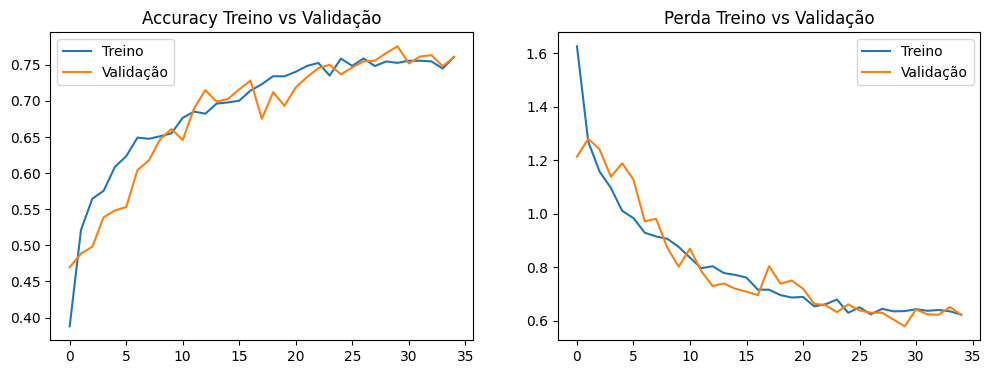

In [96]:
# Gráficos de Accuracy e Perda
plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.title('Accuracy Treino vs Validação')

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.legend()
plt.title('Perda Treino vs Validação')

plt.show()

### 📈 Gráfico de Accuracy Treino vs Validação
•	Crescimento Consistente: A accuracy de treino e validação aumentam de forma significativa ao longo das épocas, indicando que o modelo está a aprender de forma eficaz.

•	Estabilização Final: A partir da época 25, a accuracy estabiliza com pequenas oscilações, sugerindo que o modelo atingiu o seu limite de aprendizagem com os parâmetros atuais.

•	Validação Próxima ao Treino: As linhas de treino e validação acompanham-se de perto, sugerindo que o modelo generalizou bem sem sinais evidentes de overfitting.

•	Conclusão: O modelo apresenta um bom equilíbrio entre treino e validação, com uma precisão final próxima de 75%.

### 📉 Gráfico de Perda Treino vs Validação
•	Redução Significativa da Perda: Tanto a perda de treino quanto a de validação diminuem rapidamente nas primeiras épocas, demonstrando que o modelo está a otimizar os seus parâmetros corretamente.

•	Estabilização da Perda: A partir da época 20, observa-se uma estabilização nas perdas, com pequenas variações em ambas as curvas.

•	Sem Overfitting Aparente: As perdas de treino e validação permanecem próximas, sugerindo que o modelo não sofreu overfitting significativo.

•	Conclusão: A trajetória de perda valida que o modelo foi bem ajustado e convergiu para um ponto estável.

## 📊 Matriz de Confusão

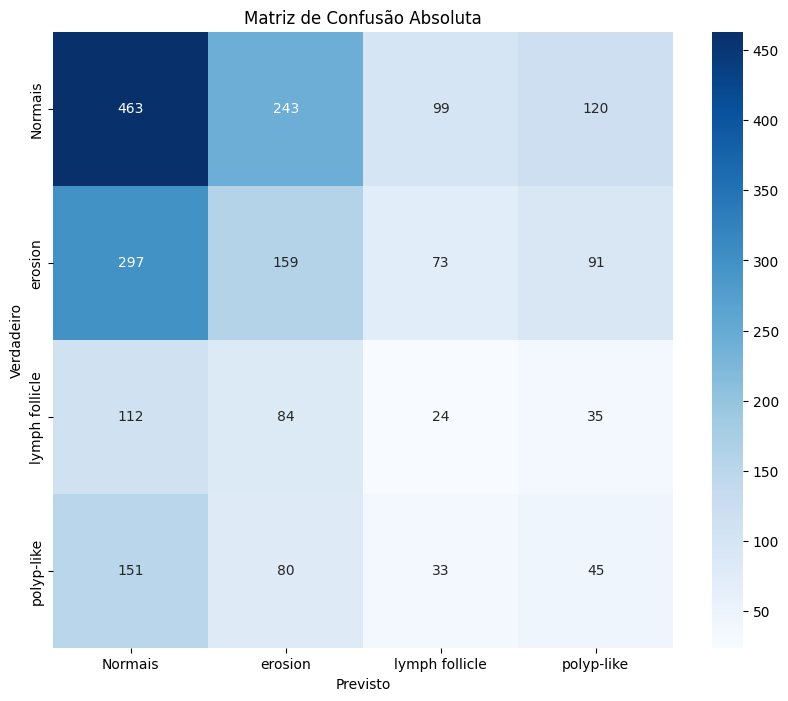

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_classes)

# 📊 Matriz de Confusão Absoluta
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Matriz de Confusão Absoluta')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')

plt.show()

A matriz de confusão apresenta os resultados detalhados da performance do modelo em cada classe após a fase de teste. Cada linha representa as classes verdadeiras, enquanto cada coluna representa as previsões do modelo.

•	Classe ‘Normais’: A classe dominante, com 463 previsões corretas, mas ainda com uma taxa significativa de classificações incorretas para as classes ‘erosion’ (243), ‘lymph follicle’ (99) e ‘polyp-like’ (120).

•	Classe ‘erosion’: Apresenta uma precisão mais baixa, com apenas 159 previsões corretas e um número considerável de previsões equivocadas para a classe ‘Normais’ (297).

•	Classe ‘lymph follicle’: A classe mais desafiadora para o modelo, com apenas 24 previsões corretas e uma grande quantidade de erros distribuídos entre ‘Normais’ (112) e ‘erosion’ (84).

•	Classe ‘polyp-like’: Apesar de apresentar uma taxa baixa de previsões corretas (33), destaca-se o número de classificações equivocadas para as classes ‘Normais’ (151) e ‘erosion’ (80).

O modelo teve um desempenho aceitável na classe ‘Normais’, mas apresentou dificuldades significativas em diferenciar as classes mais específicas, como ‘lymph follicle’ e ‘polyp-like’. Isso pode ser atribuído ao possível desequilíbrio de classes no dataset ou à similaridade visual entre as categorias.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


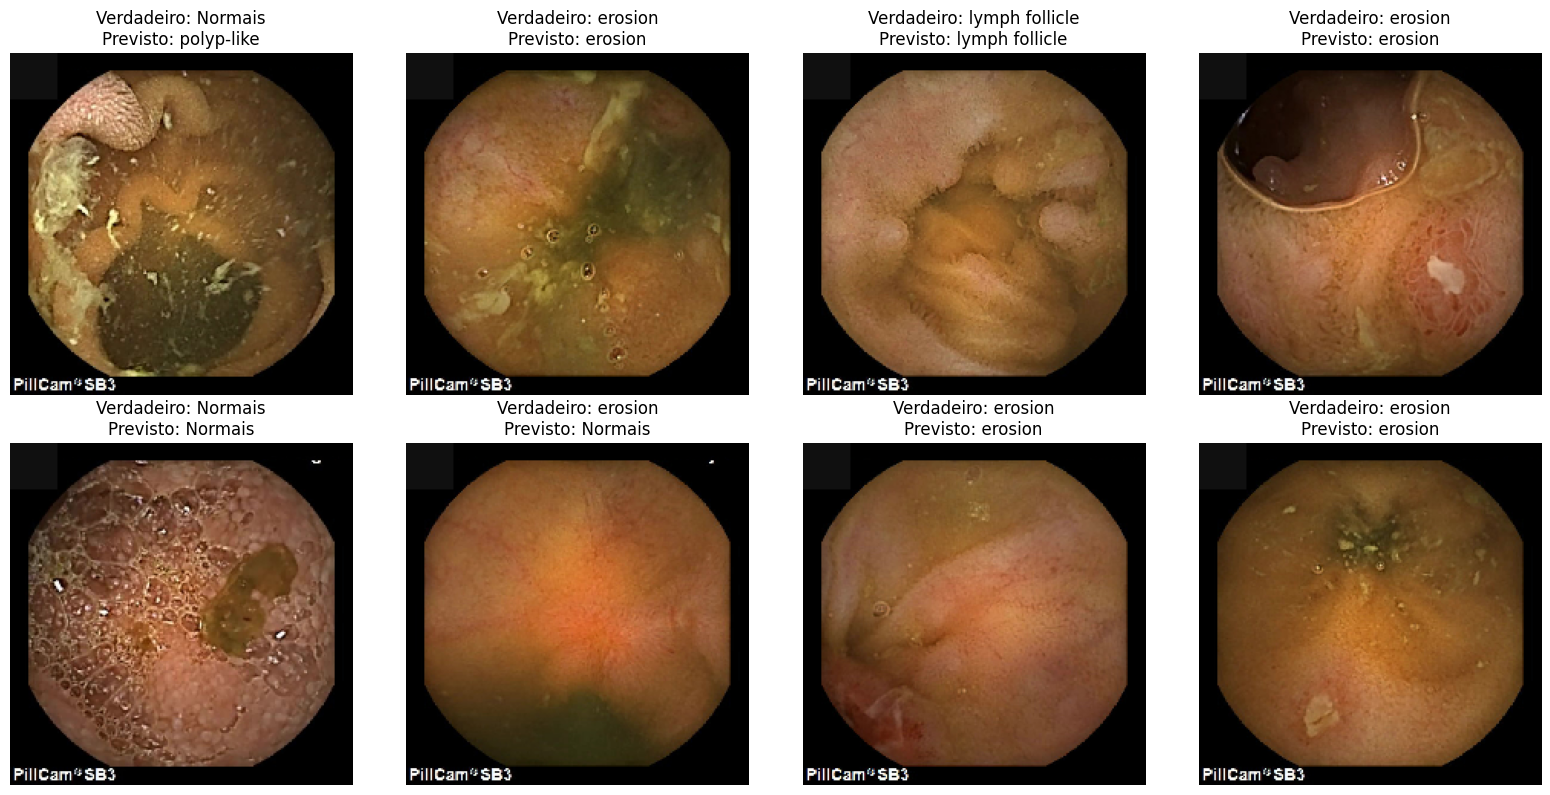

In [95]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Carregar Imagens de Teste
image_paths = test_generator.filepaths
random_indices = random.sample(range(len(image_paths)), 8)
random_images = [image_paths[i] for i in random_indices]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, img_path in enumerate(random_images):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    predicted_class = list(test_generator.class_indices.keys())[np.argmax(pred)]
    true_class = img_path.split(os.path.sep)[-2]
    
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].axis('off')
    axes[i // 4, i % 4].set_title(f"Verdadeiro: {true_class}\nPrevisto: {predicted_class}")

plt.tight_layout()
plt.show()

Nesta imagem é possível visualizar uma amostra aleatória de oito imagens do conjunto de **teste**, exibindo os respetivos rótulos verdadeiros (Verdadeiro) e os rótulos previstos pelo modelo (Previsto). Esta análise visual permite compreender melhor o desempenho do modelo em cenários concretos e identificar padrões nos erros de classificação. Neste conjunto de imagens específico, o modelo obteve uma precisão razoável, mas ainda com algumas previsões incorretas, especialmente nas classes ‘erosion’ e ‘polyp-like’, classes essas que apresentavam menor número de amostras no dataset. Mesmo assim, o modelo conseguiu identificar corretamente a maioria das amostras com uma taxa de acerto de aproximadamente 75% neste conjunto de imagens provenientes do conjunto de teste.
